# Syntax
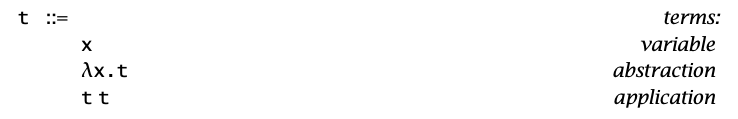

In [1]:
data Term
    = Var String
    | Lam String Term
    | App Term Term
    deriving (Eq, Show)

# Semantics

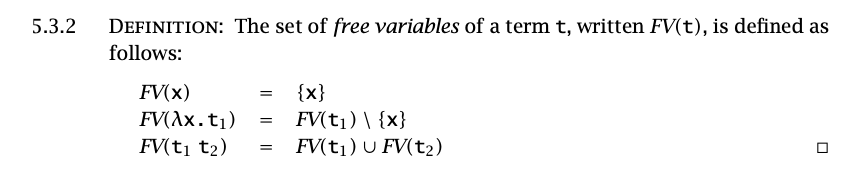

In [2]:
import Data.List

freeVar (Var x) = [x]
freeVar (Lam x t) = freeVar t \\ [x]
freeVar (App t1 t2) = freeVar t1 `union` freeVar t2

In [3]:
freeVar (Var "x")

["x"]

$\lambda x.y$

In [4]:
freeVar $ Lam "x" (Var "y")

["y"]

$\lambda x.x$

In [5]:
freeVar $ Lam "x" (Var "x")

[]

$(\lambda x.x) \space (\lambda y.y) \space z$

In [6]:
t1 = Lam "x" (Var "x")
t2 = Lam "y" (Var "a")
t3 = Var "b"
freeVar $ App (App t1 t2) t3

["a","b"]

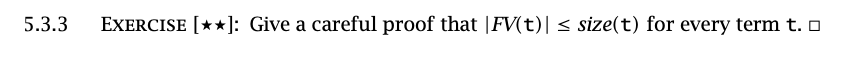

In [7]:
size (Var _) = 1
size (Lam _ t) = size t + 1
size (App t1 t2) = size t1 + size t2 + 1

In [8]:
import Test.QuickCheck

instance Arbitrary Term where
    arbitrary = sized term
        where term 0 = elements $ map Var vars
              term n = oneof [
                      elements $ map Var vars,
                      oneof $ map (\v -> Lam v <$> term (n-1)) vars,
                      App <$> term (n `div` 2) <*> term (n `div` 2)
                  ]
              vars = map (:[]) ['a'..'z']

In [9]:
prop_5_3_3 t = collect (l, s) $ l <= s
    where l = length $ freeVar t
          s = size t

quickCheck prop_5_3_3

+++ OK, passed 100 tests:
32% (1,1)
10% (1,2)
 5% (1,3)
 5% (1,4)
 5% (2,3)
 4% (2,4)
 4% (3,7)
 2% (0,3)
 2% (2,5)
 2% (3,13)
 2% (4,13)
 1% (1,5)
 1% (10,33)
 1% (11,39)
 1% (11,56)
 1% (12,53)
 1% (2,27)
 1% (2,6)
 1% (2,7)
 1% (3,15)
 1% (3,17)
 1% (3,5)
 1% (4,10)
 1% (4,12)
 1% (4,16)
 1% (4,21)
 1% (4,22)
 1% (4,8)
 1% (4,9)
 1% (5,14)
 1% (5,18)
 1% (6,16)
 1% (6,23)
 1% (7,17)
 1% (7,19)
 1% (8,27)
 1% (8,28)
 1% (9,31)

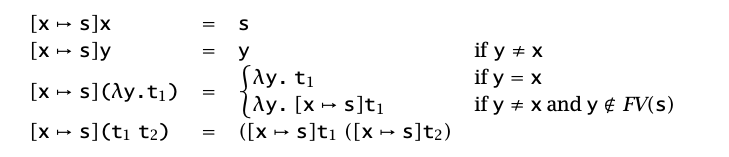
The first clause for abstractions can be dropped, since we can always assume (renaming if necessary) that the bound variable y is different from both x and the free variables of s.
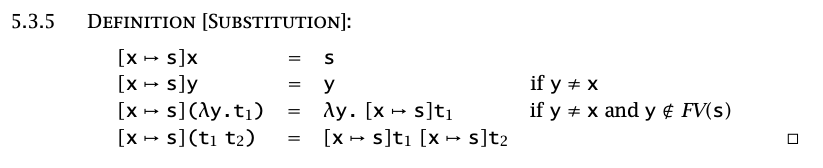

In [10]:
-- we do not implement renaming of abstraction for simplicity
subst :: String -> Term -> Term -> Term
subst x s (Var y)
    | x == y = s
    | otherwise = Var y
subst x s (Lam y t)
    | x /= y && y `notElem` freeVar s = Lam y $ subst x s t
subst x s (App t1 t2) = App t1' t2'
    where t1' = subst x s t1
          t2' = subst x s t2

$[y \mapsto \lambda x.x] y = \lambda x.x$

In [11]:
subst "y" t1 (Var "y")

Lam "x" (Var "x")

$[a \mapsto \lambda x.x] \lambda y.a = \lambda y.\lambda x.x$

In [12]:
subst "a" t1 t2

Lam "y" (Lam "x" (Var "x"))

$[a \mapsto b] (\lambda x.a) \space a = (\lambda x.b) \space b$

In [13]:
subst "a" (Var "b") $ App (Lam "x" (Var "a")) (Var "a")

App (Lam "x" (Var "b")) (Var "b")

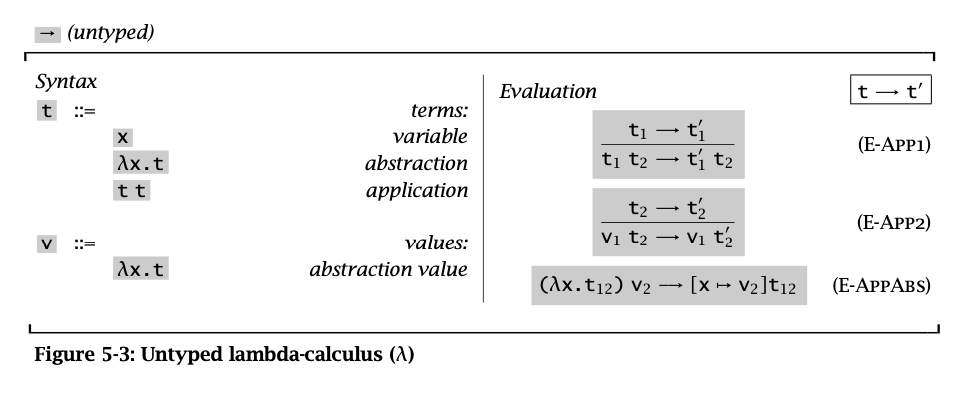

In [14]:
isVal (Lam _ _) = Prelude.True
isVal _ = Prelude.False

eval :: Term -> Maybe Term
eval t
    | isVal t = Just t
    | otherwise = do
        t' <- step t
        eval t'

step :: Term -> Maybe Term
step (App (Lam x t12) v2)
    | isVal v2 = return $ subst x v2 t12
step (App v1 t2)
    | isVal v1 = do
        t2' <- step t2
        return $ App v1 t2'
step (App t1 t2) = do
    t1' <- step t1
    return $ App t1' t2
step _ = Nothing

$(\lambda x.x) \space \lambda y.y = \lambda y.y$

In [15]:
eval $ App (Lam "x" (Var "x")) (Lam "y" (Var "y"))

Just (Lam "y" (Var "y"))

$(\lambda x. \lambda y.x) \space \lambda z.z = \lambda y. \lambda z.z$

In [16]:
eval $ App (Lam "x" (Lam "y" (Var "x"))) (Lam "z" (Var "z"))

Just (Lam "y" (Lam "z" (Var "z")))